<a href="https://colab.research.google.com/github/aldasmallthings/dataInference/blob/master/compass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# this is for authenticating data writes to my google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'datums/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import matplotlib.pyplot as plt

import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import urllib.request, json 
import random
from PIL import Image
import numpy as np

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
### pull logo metadata from the logo_repo API

with urllib.request.urlopen("https://www.compass.com/api/v3/logo_repo") as url:
    data = json.loads(url.read().decode())
    print(data)

### un-nest list of dicts associated with logos key

logo_dicts = data.get('logos')

### loop through and pull out urlImage dict value per logo metadata item

url_images = []

for item in logo_dicts:
    url_images.append(item.get('urlImage'))

### randomly sample items from the list to download the images for

batch_to_download = random.sample(url_images, 25)

### loop through random sample & download the images to a local directory

for index, image in enumerate(batch_to_download):
    urllib.request.urlretrieve(image, "/content/gdrive/My Drive/datums/bw/{}.png".format(index)) 
print('images downloaded successfully')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



images downloaded successfully


## The following approach takes <1s per picture upload an might be more straight forward than implementing a machine learning alternative to such an straight forward problem

In [0]:
### Function is going to be giving us a pass or fail given on pixel transparency threshold met

def white_to_transparency_gradient(img):
    x = np.asarray(img.convert('RGBA')).copy()
    print(x)
    x[:, :, 3] = (255 - x[:, :, :3].mean(axis=2)).astype(np.uint8)

    return Image.fromarray(x)

img = Image.open('images/test.png')
img2 = white_to_transparency_gradient(img)
img2.save("images/test5.png", "PNG")

pic = imageio.imread('images/test.png')
total_row , total_col , layers = pic.shape

im = Image.open('b&w/85.png')

def pixel_checker(image):
    result = {}
    transparent = 0
    pigment = 0
    data = im.getdata()
    if len(data[0]) < 4:
        result['error'] = 'Please only upload PNGs'
        print(data[0])
        return error
    for pixel in data:
        error = []
        if pixel == (0, 0, 0, 0):
            transparent += 1
        else:
            pigment += 1
    ratio = transparent/(pigment+transparent)
    if ratio <= 0.20:
        result['error'] = 'Please only upload PNGs with trasnparent backgrounds'
    else:
        result['success'] = 'Your picture is {} transparent'.format(round(ratio, 2))
    return result

result = pixel_checker(im)
print(result)

In [9]:
tfms = get_transforms(do_flip=False)
# data = ImageDataBunch.from_folder(bwpath, ds_tfms=tfms, size=64)

real_data = ImageDataBunch.from_folder(Path(base_dir+'/data'), 
                                       ds_tfms=tfms, 
                                       bs=bs,train='.',
                                       valid_pct=0.2, 
                                       resize_method=ResizeMethod.SQUISH)

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:272: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 100, 100]), torch.Size([3, 225, 225]), torch.Size([3, 198, 254]), torch.Size([3, 159, 317]), torch.Size([3, 201, 251]), torch.Size([3, 100, 100]), torch.Size([3, 9000, 9000]), torch.Size([3, 235, 215]), torch.Size([3, 100, 100]), torch.Size([3, 9084, 9084]), torch.Size([3, 188, 268]), torch.Size([3, 9084, 9084]), torch.Size([3, 201, 199]), torch.Size([3, 214, 235]), torch.Size([3, 100, 100]), torch.Size([3, 100, 100]), torch.Size([3, 194, 259]), torch.Size([3, 100, 100]), torch.Size([3, 183, 275]), torch.Size([3, 100, 100]), torch.Size([3, 194, 259]), torch.Size([3, 225, 225]), torch.Size([3, 100, 100]), torch.Size([3, 194, 259]), torch.Size([3, 194, 259]), torch.Size([3, 100, 100]), torch.Size([3, 183, 275]), torch.Size([3, 100, 100]), torch.Size([3, 198, 254]), torch.Size([3, 100, 100]), 

In [10]:
fnames = get_image_files(Path(base_dir+'/data'))
fnames[:5]

[PosixPath('/content/gdrive/My Drive/datums/data/black_00004.png'),
 PosixPath('/content/gdrive/My Drive/datums/data/black_00005.png'),
 PosixPath('/content/gdrive/My Drive/datums/data/black_00006.png'),
 PosixPath('/content/gdrive/My Drive/datums/data/black_00007.png'),
 PosixPath('/content/gdrive/My Drive/datums/data/black_00008.png')]

In [0]:
pat = r'/([^/]+)_\d+.png$'

In [0]:
data = ImageDataBunch.from_name_re(Path(base_dir+'/data'), 
                                   fnames, 
                                   pat, 
                                   ds_tfms=get_transforms(), 
                                   size=224, 
                                   bs=bs
                                  ).normalize(imagenet_stats)

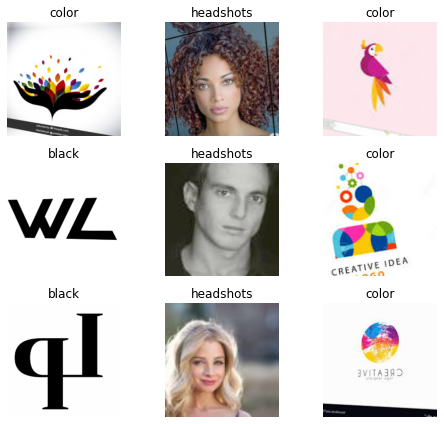

In [13]:
data.show_batch(rows=3, figsize=(7,6))

In [14]:
print(data.classes)
len(data.classes),data.c

['black', 'color', 'headshots']


(3, 3)

## Training: resnet34

*Now* we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. TLDR: We are building a model which will take images as input and will output the predicted probability for each category.

We will train for 4 epochs (4 cycles through all our data).

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.343702,0.483699,0.225000,01:04
1,1.280808,0.027241,0.000000,00:53
2,0.849746,0.015785,0.000000,00:53
3,0.625332,0.015667,0.000000,00:56


In [0]:
learn.save('first-try-last-try')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

In our particular case, the model was not confused at all! It was able to see these images apart quite easily :-)

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

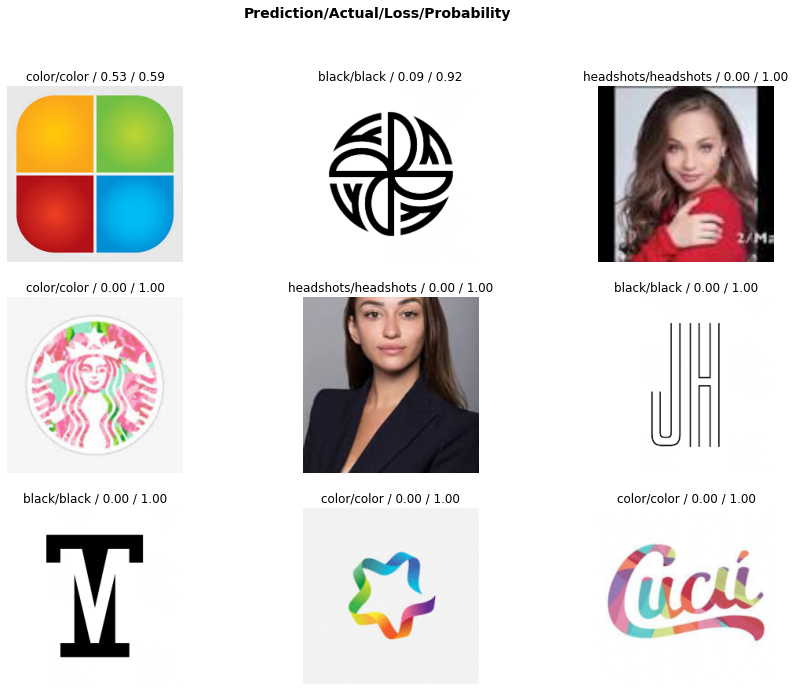

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

In [23]:
doc(interp.plot_top_losses)

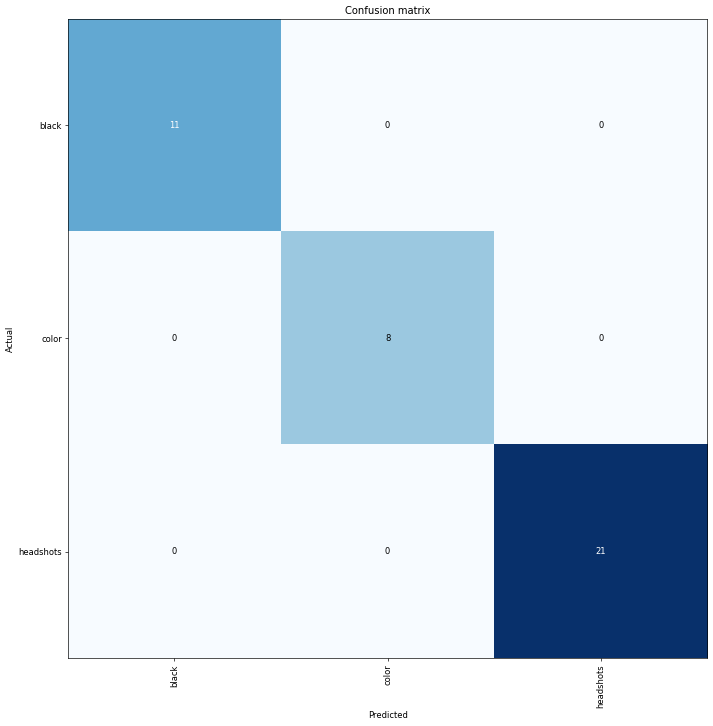

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)